# LightGBM Tuning

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NAME = 'lightgbm'

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
)

In [6]:
lags_covariates = {
    'agi-are-DE': 8,
    'agi-are-00-04': 8,
    'agi-are-05-14': 8,
    'agi-are-15-34': 8,
    'agi-are-35-59': 8,
    'agi-are-60+': 8,
    'default_lags': 1
}

In [7]:
sweep_configuration = {
    "name": f"{NAME}-expanding-window",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},  
        "multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True]},
        "use_features" :  {"values" : [True, False]},
        "use_encoders" :  {"values" : [True]},
        "use_static_covariates" :  {"values" : [False]},
        "sample_weight" : {"values" : [None, "linear", "custom"]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [lags_covariates]},
        "lags_future_covariates": {"values": [(0, 1)]},
        "num_leaves": {"values": [10, 20, 31, 40, 50]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20]},  # Max depth of trees
        "learning_rate": {"values": [0.005, 0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [250, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30, 40]},  # Minimum child samples per leaf
        "subsample": {"values": [0.8, 0.9, 1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.8, 0.9, 1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.25, 0.5, 1.0, 5.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.25, 0.5, 1.0, 5.0]},  # L2 regularization
        "subsample_freq": {"values": [0, 1, 2, 5]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [510, 1024, 2048]},  # Maximum number of bins
    }
}

In [7]:
sweep_configuration = {
    "name": f"{NAME}-expanding-window",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},  
        "multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True, False]},
        "use_static_covariates" :  {"values" : [False]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [8]},
        "lags_future_covariates": {"values": [(0,4)]},
        "num_leaves": {"values": [10, 20, 31, 40, 50]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20]},  # Max depth of trees
        "learning_rate": {"values": [0.005, 0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [250, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30]},  # Minimum child samples per leaf
        "subsample": {"values": [0.8, 0.9, 1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.8, 0.9, 1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.25, 0.5, 1.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.25, 0.5, 1.0]},  # L2 regularization
        "subsample_freq": {"values": [0, 1, 2, 5]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [510, 1024, 2048]},  # Maximum number of bins
    }
}

In [8]:
sweep_configuration = {
    "name": f"{NAME}-expanding-window",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},  
        "multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True, False]},
        "use_static_covariates" :  {"values" : [False]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [8]},
        "lags_future_covariates": {"values": [(0,4)]},
        "num_leaves": {"values": [10, 20, 31, 40, 50]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20]},  # Max depth of trees
        "learning_rate": {"values": [0.005, 0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [250, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30]},  # Minimum child samples per leaf
        "subsample": {"values": [1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0]},  # L1 regularization
        "reg_lambda": {"values": [0]},  # L2 regularization
        "subsample_freq": {"values": [0]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [510, 1024, 2048]},  # Maximum number of bins
    }
}

In [21]:
sweep_configuration = {
    "name": f"{NAME}-check-wis",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},
    "parameters": {
        "model": {"values": ["lightgbm"]},  # Changed to the provided model
        "multiple_series": {"values": [False]},  # Fixed to the provided value
        "use_covariates": {"values": [True]},  # Set to provided value
        "use_features": {"values": [True]},  # Set to provided value
        "use_encoders": {"values": [True]},  # Set to provided value
        "use_static_covariates": {"values": [False]},  # Set to provided value
        "sample_weight" : {"values" : ["linear"]},
        "lags": {"values": [8]},  # Provided value
        "lags_past_covariates": {"values": [lags_covariates]},  # Provided value
        "lags_future_covariates": {"values": [(0, 1)]},  # Provided values for future lags
        "num_leaves": {"values": [31]},  # Provided value
        "max_depth": {"values": [10]},  # Provided value
        "learning_rate": {"values": [0.005]},  # Provided value
        "n_estimators": {"values": [5000]},  # Provided value
        "min_child_samples": {"values": [30]},  # Provided value
        "subsample": {"values": [0.9]},  # Provided value
        "colsample_bytree": {"values": [0.8]},  # Provided value
        "reg_alpha": {"values": [1]},  # Provided value
        "reg_lambda": {"values": [0.5]},  # Provided value
        "subsample_freq": {"values": [2]},  # Provided value
        "min_split_gain": {"values": [0]},  # Provided value
        "max_bin": {"values": [510]},  # Provided value
    }
}

### Load data

In [8]:
get_season_end(2023)

Timestamp('2024-09-29 00:00:00')

In [9]:
get_season_start(2024)

Timestamp('2024-10-06 00:00:00')

In [10]:
targets, covariates = load_realtime_training_data()

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [11]:
targets_train, targets_validation = train_validation_split(targets, 2022)

In [12]:
def get_custom_weights(targets):

    len_before = len(targets[: get_season_end(2019)].time_index)

    len_after = len(targets[get_season_start(2020) :].time_index)

    weights = np.append(
        np.linspace(0.5, 0.5, len_before),
        np.linspace(0.5, 1, len_after)
    )

    ts_weights = TimeSeries.from_times_and_values(
        times=targets.time_index,
        values=weights
    )
    
    return ts_weights

In [13]:
custom_weights = get_custom_weights(targets)

<Axes: xlabel='date'>

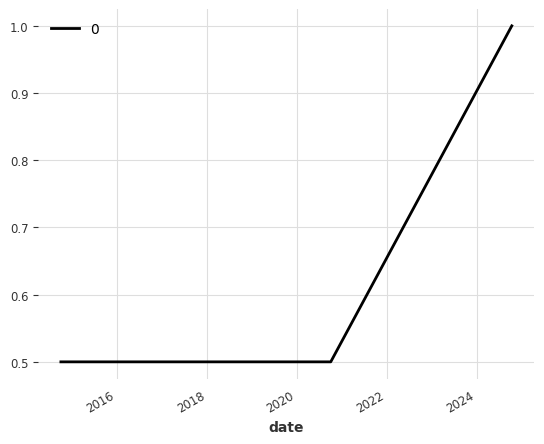

In [14]:
custom_weights.plot()

<Axes: xlabel='date'>

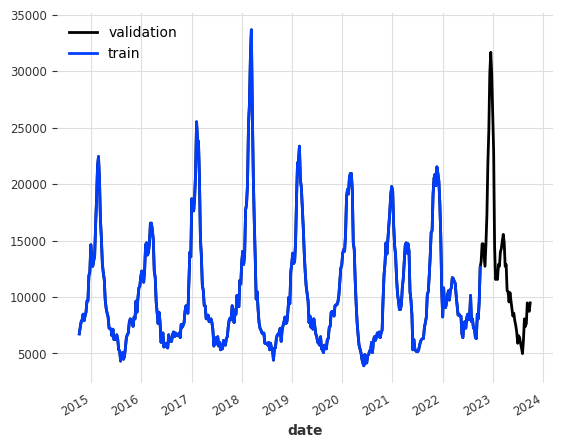

In [15]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

### Block CV

In [9]:
# Block CV
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        
        **SHARED_ARGS
    )
    
    scores = []
    k=0
    for train, validation, cov in zip(targets_train, targets_validation, covariates):
        k+=1
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{k}' : score})
        # model.reset()?
            
    avg_score = np.mean(scores) # average across all validation periods
    std = np.std(scores)
    var = np.var(scores)
    
    wandb.log({'WIS_std' : std,
               'WIS_var' : var})

    return avg_score

### Simple validation

In [10]:
# Simple validation
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                     HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)

    return score

### Multiple runs

In [11]:
RANDOM_SEEDS = [1, 2, 3]

In [12]:
# Multiple runs
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    
    scores = []
    for seed in RANDOM_SEEDS:
        model.model_params['random_state'] = seed
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{seed}' : score})
        model.reset_model()
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Expanding window

In [18]:
VALIDATION_YEARS = [2018, 2019, 2022, 2023][::-1]

In [19]:
def compute_validation_score(model, targets_train, targets_validation, covariates, 
                             horizon, num_samples, metric, metric_kwargs, enable_optimization=True, sample_weight=None):
    
    model.fit(targets_train, past_covariates=covariates, sample_weight=sample_weight)
    
    if isinstance(targets_train, list):
        validation_start = targets_train[0].end_time() + targets_train[0].freq
    else:
        validation_start = targets_train.end_time() + targets_train.freq

    hfc = model.historical_forecasts(
        series=targets_validation,
        past_covariates=covariates,
        start=validation_start,
        forecast_horizon=horizon,
        stride=1,
        last_points_only=False,
        retrain=False,
        verbose=False,
        num_samples=num_samples,
        enable_optimization=enable_optimization
    )


    scores = model.backtest(
        series=targets_validation,
        past_covariates=covariates,
        historical_forecasts=hfc,
        start=validation_start,
        forecast_horizon=horizon,
        stride=1,
        last_points_only=False,
        retrain=False,
        verbose=False,
        num_samples=num_samples,
        metric=metric, 
        metric_kwargs=metric_kwargs
    )

    score = np.mean(scores)
    
    return score if score != np.nan else float("inf")

In [20]:
# Expanding window
def objective(config):
    multiple_series = config.multiple_series
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    sample_weight = config.sample_weight
    
    model = LightGBMModel(
        lags=config.lags,
        lags_past_covariates=config.lags_past_covariates if use_covariates else None,
        lags_future_covariates=config.lags_future_covariates if use_encoders else None,
        num_leaves=config.num_leaves,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        min_child_samples=config.min_child_samples, 
        subsample=config.subsample, 
        colsample_bytree=config.colsample_bytree,  
        reg_alpha=config.reg_alpha,  # L1 regularization
        reg_lambda=config.reg_lambda,  # L2 regularization
        subsample_freq=config.subsample_freq, 
        min_split_gain=config.min_split_gain,  
        max_bin=config.max_bin,  
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        verbose=-1,
        likelihood="quantile",
        quantiles=QUANTILES,
        
        **SHARED_ARGS
    )
    
    cov = covariates
    
    if use_features:
        cov = add_features(cov)
    
    scores = []
    for validation_year in VALIDATION_YEARS:
        targets_train, targets_validation = train_validation_split(targets, validation_year)
        score = compute_validation_score(model, targets_train, targets_validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS, enable_optimization=False, 
                                         sample_weight=custom_weights if sample_weight == "custom" else sample_weight)
        scores.append(score)
        wandb.log({f'WIS_{validation_year}' : score})
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Run tuning

In [21]:
def main():
    run = wandb.init()
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [17]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="realtime-lightgbm-expanding-window")

Create sweep with ID: 7v89qwr1
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/realtime-lightgbm-expanding-window/sweeps/7v89qwr1


In [ ]:
wandb.agent(sweep_id, function=main, count=300)

wandb: Agent Starting Run: jwi1hsgw with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,413.4916
WIS_2018,349.19615
WIS_2019,359.14307
WIS_2022,536.86964
WIS_2023,408.75755


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h3yjyhag with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,394.79797
WIS_2018,322.21933
WIS_2019,338.77053
WIS_2022,514.13959
WIS_2023,404.06241


wandb: Agent Starting Run: fiothmw3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,332.28401
WIS_2018,188.38232
WIS_2019,270.68005
WIS_2022,464.24766
WIS_2023,405.82602


wandb: Agent Starting Run: phlve38n with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,407.45087
WIS_2018,330.98563
WIS_2019,348.97341
WIS_2022,538.48549
WIS_2023,411.35896


wandb: Agent Starting Run: urr10haw with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,406.96815
WIS_2018,332.03084
WIS_2019,347.87146
WIS_2022,538.70082
WIS_2023,409.26947


wandb: Agent Starting Run: pduuo8iu with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,323.23303
WIS_2018,206.95282
WIS_2019,254.03518
WIS_2022,454.36243
WIS_2023,377.58168


wandb: Agent Starting Run: rp32i0v8 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.06593
WIS_2018,226.79146
WIS_2019,275.15297
WIS_2022,461.40583
WIS_2023,376.91344


wandb: Agent Starting Run: rq4n5a5v with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,422.842
WIS_2018,364.48997
WIS_2019,381.76786
WIS_2022,528.03099
WIS_2023,417.07917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fider7vo with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,325.16307
WIS_2018,220.83724
WIS_2019,258.79066
WIS_2022,456.81062
WIS_2023,364.21374


wandb: Agent Starting Run: 50i5gljq with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,350.39235
WIS_2018,266.98607
WIS_2019,283.36336
WIS_2022,472.91984
WIS_2023,378.30011


wandb: Agent Starting Run: 0mdmn08s with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,347.80103
WIS_2018,247.62453
WIS_2019,288.44939
WIS_2022,481.69836
WIS_2023,373.43185


wandb: Agent Starting Run: 6t8r0bm0 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.99486
WIS_2018,237.05594
WIS_2019,290.63211
WIS_2022,470.42446
WIS_2023,377.86693


wandb: Agent Starting Run: 1795ivav with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.5817
WIS_2018,205.4521
WIS_2019,272.27698
WIS_2022,474.70836
WIS_2023,389.88935


wandb: Agent Starting Run: 6dbdqqdm with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,331.22903
WIS_2018,228.7153
WIS_2019,261.52632
WIS_2022,457.66468
WIS_2023,377.00982


wandb: Agent Starting Run: yusa10rh with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,460.05512
WIS_2018,348.35609
WIS_2019,403.33955
WIS_2022,598.71672
WIS_2023,489.8081


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ul7oom2l with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,345.55676
WIS_2018,241.94731
WIS_2019,287.47621
WIS_2022,479.00666
WIS_2023,373.79686


wandb: Agent Starting Run: r6fpcklf with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,445.81205
WIS_2018,343.00052
WIS_2019,398.8765
WIS_2022,562.56696
WIS_2023,478.80421


wandb: Agent Starting Run: vfoge503 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,445.82422
WIS_2018,347.82304
WIS_2019,395.69985
WIS_2022,561.62132
WIS_2023,478.15268


wandb: Agent Starting Run: z6iqaehw with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,325.62044
WIS_2018,186.28337
WIS_2019,256.90817
WIS_2022,461.84374
WIS_2023,397.44648


wandb: Agent Starting Run: k8yv45zt with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,399.14516
WIS_2018,293.75111
WIS_2019,350.81112
WIS_2022,530.5443
WIS_2023,421.4741


wandb: Agent Starting Run: d0sgt9wz with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,326.4404
WIS_2018,190.85396
WIS_2019,272.28247
WIS_2022,450.56302
WIS_2023,392.06215


wandb: Agent Starting Run: 8s6swlgo with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.04371
WIS_2018,228.4166
WIS_2019,275.81477
WIS_2022,471.02885
WIS_2023,376.91463


wandb: Agent Starting Run: e2xald6m with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.13782
WIS_2018,237.13427
WIS_2019,282.87072
WIS_2022,459.09608
WIS_2023,369.4502


wandb: Agent Starting Run: 1ts0a1em with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.53245
WIS_2018,235.87363
WIS_2019,285.01993
WIS_2022,476.92625
WIS_2023,376.30997


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hri632lo with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,342.81228
WIS_2018,234.9967
WIS_2019,287.16078
WIS_2022,472.35101
WIS_2023,376.74065


wandb: Agent Starting Run: bih36ie1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,327.32259
WIS_2018,221.47035
WIS_2019,256.11129
WIS_2022,453.09811
WIS_2023,378.61059


wandb: Agent Starting Run: t5u5uvie with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,371.59841
WIS_2018,281.37251
WIS_2019,310.95958
WIS_2022,511.62873
WIS_2023,382.43284


wandb: Agent Starting Run: zxqk2q4q with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,327.67457
WIS_2018,219.23355
WIS_2019,255.21792
WIS_2022,458.68219
WIS_2023,377.56463


wandb: Agent Starting Run: az11g3fw with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.7372
WIS_2018,244.2826
WIS_2019,269.71321
WIS_2022,466.47388
WIS_2023,370.47912


wandb: Agent Starting Run: ogxq2vrc with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.80352
WIS_2018,235.00869
WIS_2019,286.5304
WIS_2022,462.26194
WIS_2023,371.41303


wandb: Agent Starting Run: yq5yxuq3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,348.72869
WIS_2018,247.20209
WIS_2019,290.76423
WIS_2022,481.70736
WIS_2023,375.24108


wandb: Agent Starting Run: jda7m46x with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,327.39359
WIS_2018,190.31232
WIS_2019,266.20794
WIS_2022,457.8806
WIS_2023,395.17351


wandb: Agent Starting Run: irhr9tnv with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,345.0149
WIS_2018,255.10854
WIS_2019,290.76746
WIS_2022,467.14599
WIS_2023,367.03761


wandb: Agent Starting Run: divqvbkv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,321.92356
WIS_2018,185.21158
WIS_2019,253.60713
WIS_2022,461.01711
WIS_2023,387.85842


wandb: Agent Starting Run: ff3sssw1 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,331.14917
WIS_2018,217.11151
WIS_2019,271.85337
WIS_2022,454.49274
WIS_2023,381.13907


wandb: Agent Starting Run: upn356fz with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.99742
WIS_2018,239.18227
WIS_2019,279.68113
WIS_2022,471.36076
WIS_2023,365.76551


wandb: Agent Starting Run: 64o9785f with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,333.95187
WIS_2018,222.68472
WIS_2019,284.95428
WIS_2022,452.96123
WIS_2023,375.20727


wandb: Agent Starting Run: raw0c8q5 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,334.43676
WIS_2018,238.29001
WIS_2019,269.85273
WIS_2022,463.74614
WIS_2023,365.85816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v4t68y8q with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.34917
WIS_2018,233.89782
WIS_2019,274.76788
WIS_2022,467.59592
WIS_2023,365.13507


wandb: Agent Starting Run: 8dt4xtj3 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,332.83328
WIS_2018,191.61221
WIS_2019,274.19425
WIS_2022,464.32608
WIS_2023,401.20057


wandb: Agent Starting Run: h0s233hx with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,344.78676
WIS_2018,232.32867
WIS_2019,282.33032
WIS_2022,475.95807
WIS_2023,388.52999


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zcmsi3g0 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,328.26427
WIS_2018,209.45332
WIS_2019,261.59541
WIS_2022,452.00671
WIS_2023,390.00164


wandb: Agent Starting Run: ypmqge0n with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,324.9198
WIS_2018,218.26261
WIS_2019,260.4968
WIS_2022,458.51512
WIS_2023,362.40468


wandb: Agent Starting Run: t7dc3db0 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,460.86841
WIS_2018,357.67348
WIS_2019,404.23181
WIS_2022,604.9716
WIS_2023,476.59674


wandb: Agent Starting Run: i5t09h5h with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,379.64072
WIS_2018,279.86059
WIS_2019,332.08137
WIS_2022,496.70846
WIS_2023,409.91247


wandb: Agent Starting Run: ng5sxhsn with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,326.77325
WIS_2018,220.39154
WIS_2019,255.89854
WIS_2022,456.73648
WIS_2023,374.06644


wandb: Agent Starting Run: zgyrd2n8 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,414.82469
WIS_2018,352.47287
WIS_2019,366.12337
WIS_2022,525.86925
WIS_2023,414.83326


wandb: Agent Starting Run: z0ciwjjv with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,386.22906
WIS_2018,300.0396
WIS_2019,338.34173
WIS_2022,501.92512
WIS_2023,404.60979


wandb: Agent Starting Run: 9ta4ffjl with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,330.4264
WIS_2018,217.39765
WIS_2019,267.67075
WIS_2022,462.50925
WIS_2023,374.12796


wandb: Agent Starting Run: 9l2en1t3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,319.56947
WIS_2018,209.37787
WIS_2019,254.36511
WIS_2022,457.62294
WIS_2023,356.91198


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qugh15b7 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,362.02498
WIS_2018,259.62781
WIS_2019,304.28136
WIS_2022,505.60727
WIS_2023,378.58348


wandb: Agent Starting Run: jthualb1 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.65801
WIS_2018,252.12286
WIS_2019,284.56047
WIS_2022,468.70814
WIS_2023,369.24057


wandb: Agent Starting Run: 59c88nri with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,325.39679
WIS_2018,200.89512
WIS_2019,265.91936
WIS_2022,448.40485
WIS_2023,386.36781


wandb: Agent Starting Run: 09fexlxa with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,420.51598
WIS_2018,337.40765
WIS_2019,369.93489
WIS_2022,557.27424
WIS_2023,417.44713


wandb: Agent Starting Run: kd1b7cme with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,345.98931
WIS_2018,235.73804
WIS_2019,283.77411
WIS_2022,484.18197
WIS_2023,380.26312


wandb: Agent Starting Run: aos5w9lu with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,351.74979
WIS_2018,251.55987
WIS_2019,290.39532
WIS_2022,482.83005
WIS_2023,382.21392


wandb: Agent Starting Run: opue48vk with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,388.99261
WIS_2018,291.73285
WIS_2019,335.04219
WIS_2022,520.1787
WIS_2023,409.01669


wandb: Agent Starting Run: q9dfmb9r with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,342.65133
WIS_2018,225.43703
WIS_2019,284.21572
WIS_2022,484.55576
WIS_2023,376.39679


wandb: Agent Starting Run: v1h4gwpi with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,319.59206
WIS_2018,215.28057
WIS_2019,244.03864
WIS_2022,455.33703
WIS_2023,363.712


wandb: Agent Starting Run: pbgmmmjn with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,408.54492
WIS_2018,330.36322
WIS_2019,358.01439
WIS_2022,540.14416
WIS_2023,405.65792


wandb: Agent Starting Run: 6iof34g4 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,346.05698
WIS_2018,247.90288
WIS_2019,284.39049
WIS_2022,484.70511
WIS_2023,367.22945


wandb: Agent Starting Run: bwkoey9u with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.5161
WIS_2018,252.01065
WIS_2019,285.3635
WIS_2022,463.2658
WIS_2023,373.42445


wandb: Agent Starting Run: yvm4scbu with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,319.90426
WIS_2018,197.26976
WIS_2019,262.01085
WIS_2022,451.26717
WIS_2023,369.06926


wandb: Agent Starting Run: xatdl1zn with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,341.45972
WIS_2018,227.82765
WIS_2019,281.27316
WIS_2022,471.47263
WIS_2023,385.26545


wandb: Agent Starting Run: rbqqqkp8 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,316.57323
WIS_2018,194.22672
WIS_2019,251.28213
WIS_2022,451.18094
WIS_2023,369.60313


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jfc0zy4s with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,344.18779
WIS_2018,240.41721
WIS_2019,294.21507
WIS_2022,470.12108
WIS_2023,371.9978


wandb: Agent Starting Run: 1bo0z70k with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,327.05817
WIS_2018,223.97073
WIS_2019,263.72236
WIS_2022,449.88962
WIS_2023,370.64997


wandb: Agent Starting Run: z9p9i15t with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,364.06604
WIS_2018,257.14853
WIS_2019,310.48756
WIS_2022,508.34267
WIS_2023,380.28541


wandb: Agent Starting Run: wqx5hyph with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,366.2135
WIS_2018,258.70217
WIS_2019,310.67816
WIS_2022,508.91612
WIS_2023,386.55757


wandb: Agent Starting Run: 1gmzwxp0 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.89567
WIS_2018,224.46672
WIS_2019,276.25927
WIS_2022,470.57789
WIS_2023,380.27879


wandb: Agent Starting Run: wz3cv5wt with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,447.45329
WIS_2018,355.553
WIS_2019,398.88343
WIS_2022,569.84337
WIS_2023,465.53339


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8bz48p4v with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,443.16563
WIS_2018,341.68493
WIS_2019,391.75986
WIS_2022,559.20322
WIS_2023,480.0145


wandb: Agent Starting Run: 4tk8ea39 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,333.95172
WIS_2018,214.81579
WIS_2019,273.91274
WIS_2022,463.38256
WIS_2023,383.69578


wandb: Agent Starting Run: 9da6ivta with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,324.91217
WIS_2018,193.97206
WIS_2019,266.40357
WIS_2022,457.36897
WIS_2023,381.90408


wandb: Agent Starting Run: vnu8g57k with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,328.01471
WIS_2018,217.73883
WIS_2019,263.90509
WIS_2022,456.14561
WIS_2023,374.26929


wandb: Agent Starting Run: 2fgs7zvl with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,366.29595
WIS_2018,281.26126
WIS_2019,309.46739
WIS_2022,494.94659
WIS_2023,379.50856


wandb: Agent Starting Run: nhd4n549 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.88806
WIS_2018,241.47848
WIS_2019,269.83534
WIS_2022,470.09717
WIS_2023,362.14127


wandb: Agent Starting Run: knk13h4b with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.87359
WIS_2018,234.28039
WIS_2019,282.35653
WIS_2022,464.85356
WIS_2023,370.00388


wandb: Agent Starting Run: m6adk7u5 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,331.67093
WIS_2018,205.64282
WIS_2019,269.79905
WIS_2022,461.87584
WIS_2023,389.36602


wandb: Agent Starting Run: h5ssd4c2 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,321.36957
WIS_2018,184.17293
WIS_2019,253.2993
WIS_2022,462.84548
WIS_2023,385.16057


wandb: Agent Starting Run: s7i5iknx with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,445.14816
WIS_2018,338.75483
WIS_2019,389.81148
WIS_2022,571.75488
WIS_2023,480.27146


wandb: Agent Starting Run: lnrtgomn with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,456.18007
WIS_2018,355.44013
WIS_2019,411.35363
WIS_2022,585.47709
WIS_2023,472.44945


wandb: Agent Starting Run: ztxz9bkr with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,407.27613
WIS_2018,337.36961
WIS_2019,359.11604
WIS_2022,520.29797
WIS_2023,412.32089


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3ni2c8ad with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,349.38258
WIS_2018,258.91788
WIS_2019,291.71387
WIS_2022,478.69667
WIS_2023,368.20191


wandb: Agent Starting Run: cq1eeex6 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,389.76413
WIS_2018,317.52478
WIS_2019,330.38082
WIS_2022,510.13997
WIS_2023,401.01096


wandb: Agent Starting Run: t4ac7pdk with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,429.29802
WIS_2018,361.26524
WIS_2019,388.46585
WIS_2022,552.76836
WIS_2023,414.69263


wandb: Agent Starting Run: j8pu3yfa with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,325.11124
WIS_2018,207.70201
WIS_2019,263.70901
WIS_2022,444.86586
WIS_2023,384.16807


wandb: Agent Starting Run: g6yj169j with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,405.78986
WIS_2018,354.70089
WIS_2019,362.3031
WIS_2022,516.0645
WIS_2023,390.09096


wandb: Agent Starting Run: g2tavmb2 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,419.95632
WIS_2018,354.65822
WIS_2019,380.01594
WIS_2022,533.5503
WIS_2023,411.60082


wandb: Agent Starting Run: vpwdr2eh with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,350.94471
WIS_2018,250.96528
WIS_2019,293.02174
WIS_2022,484.65317
WIS_2023,375.13865


wandb: Agent Starting Run: eoafmj9f with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,345.59059
WIS_2018,256.81074
WIS_2019,295.70495
WIS_2022,466.21912
WIS_2023,363.62756


wandb: Agent Starting Run: obxajab8 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,376.87608
WIS_2018,273.42796
WIS_2019,323.58596
WIS_2022,503.9372
WIS_2023,406.5532


wandb: Agent Starting Run: s8pwe22w with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,316.45811
WIS_2018,195.09327
WIS_2019,247.8729
WIS_2022,452.80593
WIS_2023,370.06032


wandb: Agent Starting Run: 0iq4emck with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,397.91555
WIS_2018,329.27156
WIS_2019,341.39835
WIS_2022,515.04975
WIS_2023,405.94255


wandb: Agent Starting Run: hk6jjj6d with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,330.10153
WIS_2018,217.44201
WIS_2019,269.88741
WIS_2022,455.85856
WIS_2023,377.21813


wandb: Agent Starting Run: 0u514a80 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,329.03441
WIS_2018,195.04091
WIS_2019,261.57059
WIS_2022,456.31172
WIS_2023,403.21441


wandb: Agent Starting Run: t485zdij with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,320.40522
WIS_2018,215.551
WIS_2019,250.84931
WIS_2022,450.26336
WIS_2023,364.95721


wandb: Agent Starting Run: e382hci9 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,373.44271
WIS_2018,300.59946
WIS_2019,316.60915
WIS_2022,500.3406
WIS_2023,376.22162


wandb: Agent Starting Run: fg534p13 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,347.90448
WIS_2018,233.92962
WIS_2019,290.25684
WIS_2022,479.68086
WIS_2023,387.75059


wandb: Agent Starting Run: o1w4qvbz with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,316.99177
WIS_2018,195.11843
WIS_2019,258.40864
WIS_2022,448.10688
WIS_2023,366.33313


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hkmh178q with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,341.03794
WIS_2018,234.00984
WIS_2019,282.08323
WIS_2022,469.26315
WIS_2023,378.79554


wandb: Agent Starting Run: lgaukdc7 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,330.77866
WIS_2018,223.75342
WIS_2019,267.62281
WIS_2022,461.21381
WIS_2023,370.52458


wandb: Agent Starting Run: gsf0h7sl with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,351.76405
WIS_2018,242.60391
WIS_2019,289.49026
WIS_2022,483.22691
WIS_2023,391.73511


wandb: Agent Starting Run: sd0zcowu with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,341.45804
WIS_2018,248.9078
WIS_2019,285.24206
WIS_2022,467.59415
WIS_2023,364.08815


wandb: Agent Starting Run: ii1sx0rp with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,330.86787
WIS_2018,221.39393
WIS_2019,269.25161
WIS_2022,461.18849
WIS_2023,371.63746


wandb: Agent Starting Run: wqclmq22 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,367.08916
WIS_2018,282.34792
WIS_2019,313.98892
WIS_2022,497.76293
WIS_2023,374.25686


wandb: Agent Starting Run: wa2412wy with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,403.57551
WIS_2018,321.68805
WIS_2019,346.62699
WIS_2022,536.79232
WIS_2023,409.19468


wandb: Agent Starting Run: pdqlwte6 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,341.11389
WIS_2018,243.7051
WIS_2019,279.93244
WIS_2022,473.31473
WIS_2023,367.50329


wandb: Agent Starting Run: 0w3bhhc5 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,354.43096
WIS_2018,260.3859
WIS_2019,296.08534
WIS_2022,487.09394
WIS_2023,374.15865


wandb: Agent Starting Run: xa36y65r with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,439.49289
WIS_2018,335.29257
WIS_2019,394.31048
WIS_2022,552.30983
WIS_2023,476.05868


wandb: Agent Starting Run: 8lb7dpug with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.08353
WIS_2018,239.49544
WIS_2019,283.50786
WIS_2022,476.75574
WIS_2023,372.57508


wandb: Agent Starting Run: qlnol6fb with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,345.9288
WIS_2018,240.64249
WIS_2019,292.41875
WIS_2022,477.53657
WIS_2023,373.1174


wandb: Agent Starting Run: nhx5yi66 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,385.62654
WIS_2018,275.90258
WIS_2019,332.71805
WIS_2022,518.59115
WIS_2023,415.29439


wandb: Agent Starting Run: dy3r6zqa with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,345.50666
WIS_2018,249.46245
WIS_2019,284.21327
WIS_2022,479.65282
WIS_2023,368.69809


wandb: Agent Starting Run: 10xtvswe with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,476.54861
WIS_2018,392.49038
WIS_2019,431.93168
WIS_2022,593.5113
WIS_2023,488.26107


wandb: Agent Starting Run: 0ryrtv20 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,359.55841
WIS_2018,263.71505
WIS_2019,308.46163
WIS_2022,491.7769
WIS_2023,374.28005


wandb: Agent Starting Run: dod3n8ql with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,319.97144
WIS_2018,189.82274
WIS_2019,250.31107
WIS_2022,454.76153
WIS_2023,384.9904


wandb: Agent Starting Run: gzk70eln with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,391.99789
WIS_2018,326.44915
WIS_2019,334.18304
WIS_2022,507.9025
WIS_2023,399.45685


wandb: Agent Starting Run: c9t4bpsi with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,453.30193
WIS_2018,366.05209
WIS_2019,407.58082
WIS_2022,569.53939
WIS_2023,470.03543


wandb: Agent Starting Run: txd6ysl5 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,323.7139
WIS_2018,223.90829
WIS_2019,255.05718
WIS_2022,456.24366
WIS_2023,359.64646


wandb: Agent Starting Run: 95nkcer4 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.44882
WIS_2018,238.31049
WIS_2019,283.86566
WIS_2022,474.08452
WIS_2023,377.53463


wandb: Agent Starting Run: woqbqpdi with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,374.72262
WIS_2018,296.23917
WIS_2019,308.29564
WIS_2022,501.25544
WIS_2023,393.10023


wandb: Agent Starting Run: fq1h10ng with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,376.16724
WIS_2018,286.84332
WIS_2019,324.30358
WIS_2022,486.69433
WIS_2023,406.82772


wandb: Agent Starting Run: dpxmw0uc with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,336.91896
WIS_2018,227.50273
WIS_2019,268.02354
WIS_2022,475.5416
WIS_2023,376.60798


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6dy7zqj3 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.88838
WIS_2018,233.89771
WIS_2019,277.35805
WIS_2022,466.6014
WIS_2023,365.69636


wandb: Agent Starting Run: nghprj2s with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.11484
WIS_2018,226.78154
WIS_2019,275.12008
WIS_2022,473.81362
WIS_2023,376.74412


wandb: Agent Starting Run: ag1hctf2 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,356.54879
WIS_2018,259.76207
WIS_2019,299.55535
WIS_2022,491.3796
WIS_2023,375.49816


wandb: Agent Starting Run: 4hlotvgc with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,318.92171
WIS_2018,190.75828
WIS_2019,252.28185
WIS_2022,451.84318
WIS_2023,380.80354


wandb: Agent Starting Run: 1yro811q with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,328.30511
WIS_2018,217.50739
WIS_2019,264.00124
WIS_2022,454.19099
WIS_2023,377.5208


wandb: Agent Starting Run: xi4h4dlf with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,441.86026
WIS_2018,330.27473
WIS_2019,385.18213
WIS_2022,559.01279
WIS_2023,492.9714


wandb: Agent Starting Run: 8s7u7tdl with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,336.3474
WIS_2018,230.57283
WIS_2019,275.82152
WIS_2022,464.4892
WIS_2023,374.50604


wandb: Agent Starting Run: 6g3y0rw3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,340.52288
WIS_2018,241.63905
WIS_2019,282.12456
WIS_2022,466.38359
WIS_2023,371.9443


wandb: Agent Starting Run: dwdwuglm with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,446.19133
WIS_2018,337.4834
WIS_2019,391.02287
WIS_2022,570.37443
WIS_2023,485.88461


wandb: Agent Starting Run: 3yurcsgs with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,329.64449
WIS_2018,195.43303
WIS_2019,268.41053
WIS_2022,457.1988
WIS_2023,397.53561


wandb: Agent Starting Run: aapztf0y with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,348.90315
WIS_2018,217.22191
WIS_2019,277.14824
WIS_2022,503.31912
WIS_2023,397.92334


wandb: Agent Starting Run: rudglcvo with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,361.43804
WIS_2018,265.89745
WIS_2019,302.92746
WIS_2022,506.52701
WIS_2023,370.40023


wandb: Agent Starting Run: 5q43dr0a with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,336.15615
WIS_2018,223.74591
WIS_2019,278.3616
WIS_2022,469.13158
WIS_2023,373.3855


wandb: Agent Starting Run: o3g6rf1v with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.40178
WIS_2018,225.02099
WIS_2019,278.99326
WIS_2022,485.63997
WIS_2023,383.9529


wandb: Agent Starting Run: a7f7l12n with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,339.34112
WIS_2018,242.96118
WIS_2019,281.04172
WIS_2022,465.43593
WIS_2023,367.92565


wandb: Agent Starting Run: beb2rilt with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,332.19355
WIS_2018,203.08286
WIS_2019,270.34809
WIS_2022,466.19561
WIS_2023,389.14765


wandb: Agent Starting Run: hagqflhv with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	sample_weight: None
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.73462
WIS_2018,232.45092
WIS_2019,271.51169
WIS_2022,476.69003
WIS_2023,370.28582


wandb: Agent Starting Run: r1x3gnue with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,346.40724
WIS_2018,253.29377
WIS_2019,284.54975
WIS_2022,476.12868
WIS_2023,371.65677


wandb: Agent Starting Run: m38twbm8 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,346.15522
WIS_2018,247.66452
WIS_2019,291.94794
WIS_2022,469.27919
WIS_2023,375.72922


wandb: Agent Starting Run: p40rs0ei with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,412.79899
WIS_2018,341.84376
WIS_2019,355.62841
WIS_2022,529.19155
WIS_2023,424.53223


wandb: Agent Starting Run: sdp219d5 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,342.63653
WIS_2018,210.90498
WIS_2019,278.91221
WIS_2022,490.70538
WIS_2023,390.02354


wandb: Agent Starting Run: dxreoy4q with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,342.29765
WIS_2018,232.07272
WIS_2019,285.95008
WIS_2022,461.32119
WIS_2023,389.84659


wandb: Agent Starting Run: 6q9z675v with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 5
wandb: 	sample_weight: linear
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.64663
WIS_2018,235.35057
WIS_2019,277.20843
WIS_2022,473.31745
WIS_2023,368.71009


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: azj404ri with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [ ]:
wandb.agent(sweep_id='7v89qwr1', function=main, count=1000, project="realtime-lightgbm-expanding-window")

wandb: Agent Starting Run: fgd24ds6 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,326.96841
WIS_2018,228.07894
WIS_2019,257.59767
WIS_2022,460.82002
WIS_2023,361.37703


wandb: Agent Starting Run: sucesfd3 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,346.07616
WIS_2018,250.67319
WIS_2019,293.74288
WIS_2022,471.79948
WIS_2023,368.08909


wandb: Agent Starting Run: 0p2wfgpk with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 5
wandb: 	sample_weight: None
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,373.3825
WIS_2018,265.69771
WIS_2019,318.8329
WIS_2022,511.05722
WIS_2023,397.94216


wandb: Agent Starting Run: 8yhxy3oh with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,341.34066
WIS_2018,249.98604
WIS_2019,285.70835
WIS_2022,466.78084
WIS_2023,362.88743


wandb: Agent Starting Run: s5gpt3rs with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,352.97674
WIS_2018,260.79909
WIS_2019,296.66528
WIS_2022,476.17931
WIS_2023,378.26328


wandb: Agent Starting Run: i8emf45g with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,355.96819
WIS_2018,249.64593
WIS_2019,297.48727
WIS_2022,499.21126
WIS_2023,377.5283


wandb: Agent Starting Run: t8y4izvj with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,344.0694
WIS_2018,253.02494
WIS_2019,288.19341
WIS_2022,466.06328
WIS_2023,368.99595


wandb: Agent Starting Run: qgfpxszc with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,318.54567
WIS_2018,190.8136
WIS_2019,251.67456
WIS_2022,466.21122
WIS_2023,365.48329


wandb: Agent Starting Run: uf5dwgu5 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 2
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,363.57779
WIS_2018,264.93248
WIS_2019,307.95338
WIS_2022,477.11156
WIS_2023,404.31375


wandb: Agent Starting Run: apsru3d4 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,339.46712
WIS_2018,244.31209
WIS_2019,276.90824
WIS_2022,469.56344
WIS_2023,367.08472


wandb: Agent Starting Run: bc002wob with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0
wandb: 	sample_weight: custom
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,316.62649
WIS_2018,193.73063
WIS_2019,251.37025
WIS_2022,453.21332
WIS_2023,368.19175


wandb: Agent Starting Run: cgan8tmw with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 5
wandb: 	reg_lambda: 0
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,404.44361
WIS_2018,342.28735
WIS_2019,349.02862
WIS_2022,535.15136
WIS_2023,391.30709


wandb: Agent Starting Run: f0sxipmg with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 1
wandb: 	sample_weight: linear
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,344.20936
WIS_2018,243.39299
WIS_2019,283.39906
WIS_2022,473.20547
WIS_2023,376.83991


wandb: Agent Starting Run: m8ttpmfb with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 40
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.25
wandb: 	sample_weight: custom
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,317.56542
WIS_2018,205.93218
WIS_2019,243.3755
WIS_2022,449.39008
WIS_2023,371.5639


wandb: Agent Starting Run: ajwla45p with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 1]
wandb: 	lags_past_covariates: {'agi-are-00-04': 8, 'agi-are-05-14': 8, 'agi-are-15-34': 8, 'agi-are-35-59': 8, 'agi-are-60+': 8, 'agi-are-DE': 8, 'default_lags': 1}
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0.25
wandb: 	reg_lambda: 0.5
wandb: 	sample_weight: custom
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
